In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class Frog:
    def __init__(self, n=10, gamma=0.99, initial_alpha=0.1, initial_eps=0.9, num_simulations = 50,
                 hyperparameter_scheme=2, rewards_choice=2
                ):
        self.n = n
        self.gamma = gamma
        self.initial_alpha = initial_alpha
        self.initial_eps = initial_eps
        self.state_space = list(range(n+1))
        self.terminal_space = [0, n]
        self.action_space = ['A', 'B']
        
        self.hyperparameter_scheme = hyperparameter_scheme
        self.rewards_choice = rewards_choice
        
        #initialization - might impact the speed of training (especially in early stages), but should not impact the outcome
        #self.Q = np.zeros([len(self.state_space), len(self.action_space)])
        self.Q = np.random.rand( len(self.state_space), len(self.action_space))
        
        self.num_simulations = num_simulations
        self.simulated_rewards = []
    
    
    def eps_greedy_action(self, eps):
        rv = np.random.uniform(0,1)
        if rv < eps:
            #random action
            return np.random.choice(self.action_space)
        else:
            #follow the best action
            return self.action_space[np.argmax(self.Q[self.state, :])]

    
    def action_A(self, state):
        rv = np.random.uniform(0,1)
        if rv < float(state)/self.n:
            return state - 1
        else:
            return state + 1
        
    def action_B(self, state):
        state_space = list(self.state_space)
        state_space.pop(state)
        return np.random.choice(state_space)
    
    def choose_reward_function(self, state):
        if self.rewards_choice == 1:
            return self.get_reward(state)
        elif self.rewards_choice == 2:
            return self.get_reward2(state)
        elif self.rewards_choice == 3:
            return self.get_reward3(state)
        elif self.rewards_choice == 4:
            return self.get_reward4(state)
        else:
            print("ERROR! Unknown reward function")
    
    def get_reward(self, state):
        #reward assignment - you can experiment with different rewards
        return float(state)/self.n
        
    def get_reward2(self, state):
        #reward assignment - you can experiment with different rewards
        if state == 0:
            return 0
        elif state == self.n:
            return 1
        else:
            return 0

    def get_reward3(self, state):
        #reward assignment 
        if state == 0:
            return -1
        elif state == self.n:
            return 1
        else:
            return 0

    def get_reward4(self, state):
        #reward assignment 
        if float(state) == 0:
            return 0
        else:
            return 1-1/float(state)**2
        
    def simulate(self, num_simulation):
        simulated_rewards = []
        for i in range(num_simulation):
            state = np.random.randint(1, self.n - 1)
            reward = 0
            while state not in self.terminal_space:
                #follow the best policy
                action = self.action_space[np.argmax(self.Q[state, :])]            
                if action == 'A':
                    state_new = self.action_A(state)
                else:
                    state_new = self.action_B(state)
                reward += self.choose_reward_function(state_new)
                state = state_new   
            simulated_rewards.append(reward)
        #return cumlated rewards over num_episode simulations for a given policy
        return np.mean(simulated_rewards)
    
    def simulate_for_large_n(self, num_simulation):
        #this function might be useful for testing/debugging your code for large n
        simulated_rewards = []
        for i in range(num_simulation):
            state = np.random.randint(1, self.n - 1)
            reward = 0
            num_iter = 0
            while state not in self.terminal_space and (num_iter<0.5e7):
                #with a small probability pick action B not to be stuck in the infinite loop traversing the lilypads,
                #otherwise follow the best policy
                rv = np.random.uniform(0,1)
                if rv < 1e-2:
                    action = 'B'
                else:
                    action = self.action_space[np.argmax(self.Q[state, :])]              
                if action == 'A':
                    state_new = self.action_A(state)
                else:
                    state_new = self.action_B(state)
                reward += self.choose_reward_function(state_new)
                state = state_new
                num_iter +=1
            if (num_iter<0.5e7):
                simulated_rewards.append(reward)
            else: 
                print("Dropped rewards due to large time needed to simulate")
        #return cumlated rewards over num_episode simulations for a given policy (this value is calibrated to n=25)
        return np.mean(simulated_rewards)
    
    def choose_hyperparameter_scheme(self, i, num_episode):
        if self.hyperparameter_scheme == 1:
            return self.my_hyperparameter_scheme_1(i, num_episode)
        elif self.hyperparameter_scheme == 2:
            return self.my_hyperparameter_scheme_2(i, num_episode)
        else:
            print("ERROR! Unknown hyperparameter scheme")
    
    def my_hyperparameter_scheme_1(self, i, num_episode):
        if i<500:
            eps =  self.    initial_eps
            alpha = float(self.initial_alpha*(num_episode - i))/num_episode
        else:
            eps = 0
            alpha = float(self.initial_alpha*(num_episode - i))/num_episode/10
        return [eps, alpha]
    
    def my_hyperparameter_scheme_2(self, i, num_episode):
        eps =  self.initial_eps
        alpha = float(self.initial_alpha*(num_episode - i))/num_episode
        return [eps, alpha]

    def q_learning(self, num_episode):
        for i in range(num_episode):
            print("training episode", i)
            self.state = np.random.randint(1, self.n - 1)
            
            #my hyperparameter scheme - feel free to implement your own
            [eps, alpha] = self.choose_hyperparameter_scheme(i, num_episode)

            while self.state not in self.terminal_space:
                #epsilon-greedy action selection
                action = self.eps_greedy_action(eps)
                #follow action to a new state
                if action == 'A':
                    state_new = self.action_A(self.state)
                else:
                    state_new = self.action_B(self.state)
                #get reward at a new state
                reward = self.choose_reward_function(state_new)
                #Q-update
                self.Q[self.state, self.action_space.index(action)] += alpha * (reward + self.gamma * np.max(self.Q[state_new, :]) - self.Q[self.state, self.action_space.index(action)])
                self.state = state_new
                
            #now simulated rewards for the fixed Q table
            self.simulated_rewards.append(self.simulate(self.num_simulations)) 
            

    def all_plots(self):
        plt.figure(figsize=(15, 4))
        plt.subplot(121)
        plt.title("Q*-values")
        plt.plot(self.Q[:,0], label='A')
        plt.plot(self.Q[:,1], label='B')
        plt.xlabel('State')
        plt.xlim((1, self.n-1))
        plt.xticks(range(1, self.n))
        plt.legend()
        plt.subplot(122)
        plt.title("Average Cumulative Rewards Over 10 Simulations")
        plt.plot(pd.Series(self.simulated_rewards))
        plt.plot(pd.Series(self.simulated_rewards).rolling(10).mean())
        plt.xlabel('Training Episode')
        plt.show()    

training episode 0
training episode 1
training episode 2
training episode 3
training episode 4
training episode 5
training episode 6
training episode 7
training episode 8
training episode 9
training episode 10
training episode 11
training episode 12
training episode 13
training episode 14
training episode 15
training episode 16
training episode 17
training episode 18
training episode 19
training episode 20
training episode 21
training episode 22
training episode 23
training episode 24
training episode 25
training episode 26
training episode 27
training episode 28
training episode 29
training episode 30
training episode 31
training episode 32
training episode 33
training episode 34
training episode 35
training episode 36
training episode 37
training episode 38
training episode 39
training episode 40
training episode 41
training episode 42
training episode 43
training episode 44
training episode 45
training episode 46
training episode 47
training episode 48
training episode 49
training e

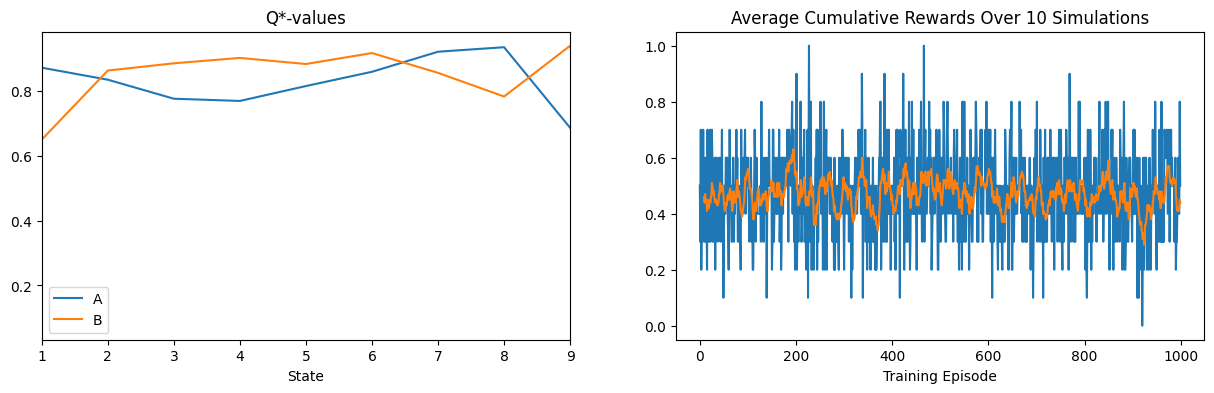

training episode 0
training episode 1
training episode 2
training episode 3
training episode 4
training episode 5
training episode 6
training episode 7
training episode 8
training episode 9
training episode 10
training episode 11
training episode 12
training episode 13
training episode 14
training episode 15
training episode 16
training episode 17
training episode 18
training episode 19
training episode 20
training episode 21
training episode 22
training episode 23
training episode 24
training episode 25
training episode 26
training episode 27
training episode 28
training episode 29
training episode 30
training episode 31
training episode 32
training episode 33
training episode 34
training episode 35
training episode 36
training episode 37
training episode 38
training episode 39
training episode 40
training episode 41
training episode 42
training episode 43
training episode 44
training episode 45
training episode 46
training episode 47
training episode 48
training episode 49
training e

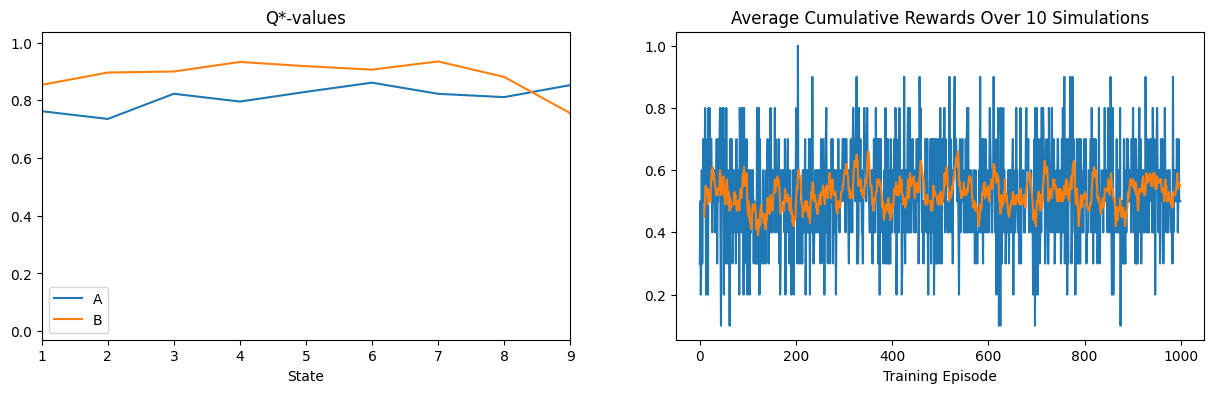

In [28]:
#myFrog = Frog(n=10, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 1, rewards_choice = 1)
#myFrog.q_learning(1000)
#myFrog.all_plots()
myFrog = Frog(n=10, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 1, rewards_choice = 2)
myFrog.q_learning(1000)
myFrog.all_plots()
myFrog = Frog(n=10, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 2, rewards_choice = 2)
myFrog.q_learning(1000)
myFrog.all_plots()
#myFrog = Frog(n=10, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 2, rewards_choice = 3)
#myFrog.q_learning(2000)
#myFrog.all_plots()
#myFrog = Frog(n=10, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 1, rewards_choice = 4)
#myFrog.q_learning(1000)
#myFrog.all_plots()

training episode 0
training episode 1
training episode 2
training episode 3
training episode 4
training episode 5
training episode 6
training episode 7
training episode 8
training episode 9
training episode 10
training episode 11
training episode 12
training episode 13
training episode 14
training episode 15
training episode 16
training episode 17
training episode 18
training episode 19
training episode 20
training episode 21
training episode 22
training episode 23
training episode 24
training episode 25
training episode 26
training episode 27
training episode 28
training episode 29
training episode 30
training episode 31
training episode 32
training episode 33
training episode 34
training episode 35
training episode 36
training episode 37
training episode 38
training episode 39
training episode 40
training episode 41
training episode 42
training episode 43
training episode 44
training episode 45
training episode 46
training episode 47
training episode 48
training episode 49
training e

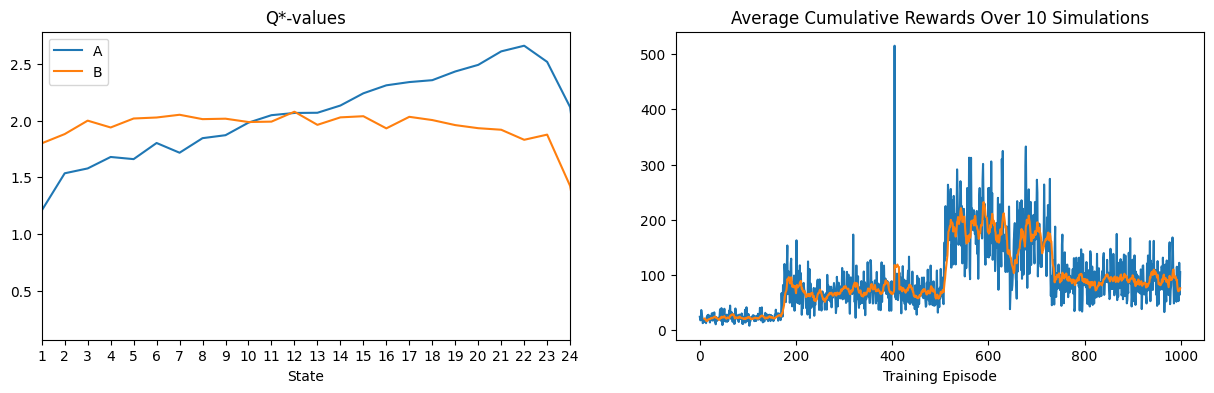

In [25]:
myFrog = Frog(n=25, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 2, rewards_choice = 1)
myFrog.q_learning(1000)
myFrog.all_plots()

training episode 0
training episode 1
training episode 2
training episode 3
training episode 4
training episode 5
training episode 6
training episode 7
training episode 8
training episode 9
training episode 10
training episode 11
training episode 12
training episode 13
training episode 14
training episode 15
training episode 16
training episode 17
training episode 18
training episode 19
training episode 20
training episode 21
training episode 22
training episode 23
training episode 24
training episode 25
training episode 26
training episode 27
training episode 28
training episode 29
training episode 30
training episode 31
training episode 32
training episode 33
training episode 34
training episode 35
training episode 36
training episode 37
training episode 38
training episode 39
training episode 40
training episode 41
training episode 42
training episode 43
training episode 44
training episode 45
training episode 46
training episode 47
training episode 48
training episode 49
training e

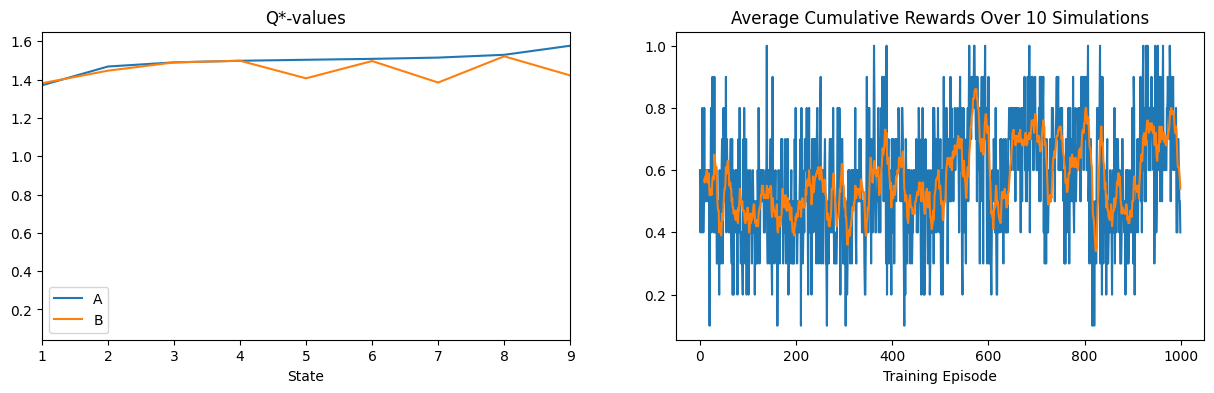

In [26]:
myFrog = Frog(n=10, gamma = 0.9999, initial_alpha = 0.2, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 1, rewards_choice = 2)
myFrog.q_learning(1000)
myFrog.all_plots()